# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Read Inputs into data frame

In [2]:
aisles=pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\aisles.csv')
departments=pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\departments.csv')
order_products_train=pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\order_products__train.csv')
order_products_prior=pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\order_products__prior.csv')
orders=pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\orders.csv')
products=pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\products.csv')


Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [3]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


Now, let's concatenate them in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers

In [4]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


# Missing Data in all orders

In [5]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data


,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


There is no missing data in order_products_all dataset

# Reorder Frequency

In [6]:
grouped = pd.DataFrame(order_products_all.groupby("reordered")["product_id"].agg(Total_products ='count')).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped


,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


59 % of ordered products are previously ordered by customers.

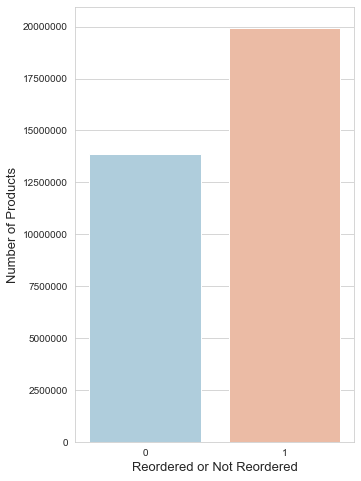

In [7]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# To predict which previously purchased products will be in a user’s next order

Step 1 We will start with reading the orders file.

In [8]:
orders_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\orders.csv', usecols=["order_id","user_id","order_number"])

Since the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

Step 2 Create data frame with old purchase

In [9]:
# read the prior order file #
prior_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\order_products__prior.csv')

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


Step 3 Create data frame with latest purchase

In [10]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


Step 4. Get count of Number of reorders

In [11]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


Step 5 merge the prior df with latest df

In [12]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

In [13]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\order_products__train.csv', usecols=["order_id"])
train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


Step 6 Get distinct order id in train_df. This will help in joining the data frame with orders

In [14]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


join with Orders data frame

In [15]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [16]:
test_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\sample_submission.csv', usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


Step 7 : Prepare test data frames

In [17]:
print(train_df.shape, test_df.shape)

(131209, 2) (75000, 2)


Step 8: Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [18]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [19]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0


In [21]:
products_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\products.csv', usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


Step 9 : Add more features to training data from Products data frame

In [22]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [23]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21


Now we have all the products that has been purchased previously by the customer along with some characteristics / featrures. So we can use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [24]:
train_y_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\order_products__train.csv', usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


# Xgboost

In [28]:
!pip install xgboost

In [29]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
X=train_df.drop('reordered',axis=1)

In [31]:
X.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [32]:
Y =train_df['reordered']

In [33]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

Step 10: split data into train and test sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [35]:
model = XGBClassifier()

Step 11: Train the model using XGBClassifier

In [36]:
model.fit(X_train, y_train)

C:\Users\Thinkpad\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [37]:
y_pred = model.predict(X_test)

In [38]:
predictions = [round(value) for value in y_pred]

In [39]:
accuracy = accuracy_score(y_test, predictions)

## Accuracy for the XGBoost Classifier

In [40]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 90.47%


In [41]:
# target variable for train set #
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

(8474661, 6) (4833292, 6)


Step 12: Create XGb function

In [42]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

Step 13: Run the XGB function on training np array

In [44]:
# run the xgboost model #
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.loc[out_df["Pred"].astype('int')==1]

[14:50:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [45]:
# when there are more than 1 product, merge them to a single string #
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

Step 14: Load result in the output file

In [48]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\sample_submission.csv', usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv(r'C:\Users\Thinkpad\Documents\SpringBoard Files\Instacart\xgb_starter_3450.csv', index=False)

In [49]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
3052321,2634088,11335,6873,1,0,0.0,83,4
5273294,3379345,104957,15923,1,0,0.0,67,20
6564246,1344587,174152,45692,1,0,0.0,107,19
7705447,2206969,196469,31205,1,0,0.0,26,7
6947171,1103780,57331,28599,1,0,0.0,130,14
...,...,...,...,...,...,...,...,...
1965286,1099888,79357,8277,9,8,0.0,24,4
4473121,256984,62140,42959,1,0,0.0,74,17
8158334,355337,70111,24341,1,0,0.0,31,7
6278263,1455864,170500,11097,1,0,0.0,30,6


# Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [52]:
#fitting the model
clf.fit(X_train, y_train)

LogisticRegression(C=0.02)

In [53]:
#predictions
pred=clf.predict(X_test)

In [54]:
#accuracy score of Logistic Regression Model
print(accuracy_score(pred, y_test))

0.9019834165224757


# RandomForest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [57]:
clfrf.fit(X_train, y_train)

C:\Users\Thinkpad\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Thinkpad\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


RandomForestClassifier(max_depth=11, max_features='log2',
                       min_samples_split=1000, n_estimators=24, oob_score=True)

In [58]:
#predictions
predrf=clfrf.predict(X_test)

In [59]:
#accuracy score for the random forest model
accuracy_score(predrf, y_test)

0.9045354083955777

# Lightgbm

In [62]:
pip install lightgbm

In [63]:
import lightgbm as lgb

In [64]:
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

In [65]:
model= lgb.LGBMClassifier()

In [66]:
model.fit(X_train, y_train)

LGBMClassifier()

In [67]:
pred=model.predict(X_test)

In [68]:
#accuracy score of Light GBM
print(accuracy_score(pred, y_test))

0.9046877340979654


# Conculsion

For modelling we got to use Xgboost,logistic,Randomforest and Lightgbm.Both Xgboost and lightgbm are used to improve the accuracy of the model and I conclude that LGBM is slightly more accurate with 90.46% than XG-Boost in this case.